In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from collections import Counter
import matplotlib.pyplot as plt
import time
import random

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_size, output_size,
                 n_layers=1,batch_first=True, dropout_rate=0.0, rnn_type='GRU'):
        super(RNN, self).__init__()
        self.batch_first = batch_first
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.rnn_type = rnn_type

        self.encoder = nn.Embedding(input_size, embedding_dim=embed_dim)
        
        if self.rnn_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_size, n_layers, dropout=self.dropout_rate, batch_first=batch_first)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_size, n_layers, dropout=self.dropout_rate, batch_first=batch_first)
        self.lin1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.decoder = nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, inputs):
        
        props = self.encoder(inputs)
        props, hidden = self.rnn(props)
        props = self.lin1(props)
        props = self.relu(props)
        props = self.decoder(props)        
        output = self.softmax(props)
        return output,hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

(array([4.3560e+03, 6.0811e+04, 1.0800e+02, 2.3000e+01, 1.2000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0. ,  11.4,  22.8,  34.2,  45.6,  57. ,  68.4,  79.8,  91.2,
        102.6, 114. ]),
 <a list of 10 Patch objects>)

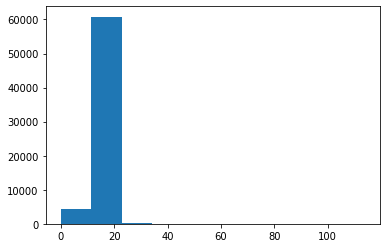

In [4]:
f = open("/content/drive/My Drive/datasets/Neplai Word Predictor/65k_cleaned.txt", "r", encoding="utf8")
text = f.read()
f.close()
sentences = text.split("\n")
random.shuffle(sentences)
words = []
sens_len = []
for s in sentences:
    w_s = s.split()
    sens_len.append(len(w_s))
    
    for w in s.split():
        words.append(w)
plt.hist(sens_len)

In [5]:
vocab_counter = Counter(words)
threshold = 2
vocab = ["<UNK>"]+[w for (w, c) in vocab_counter.most_common() if c >= threshold]

In [6]:
vocab_len = len(vocab)
vocab_len

46337

In [7]:
max_len = 20

In [8]:
def tensor_from_sentences(sentences,vocab, max_len=30):
    start = time.time()
    X = []
    Y = []
    vocab_len = len(vocab)
    for s in sentences:
        w_s = s.split()
#         print(w_s)
        idx_ip = [vocab.index(w) if w in vocab else 0 for w in w_s]
        len_words = len(idx_ip)
        
        if len_words < max_len:
            pad = [0] * (max_len - len_words)
            idx_ip += pad
        else :
            idx_ip = idx_ip[:max_len]
        
        idx_op = idx_ip[1:] + [0]
        # one_hot = []
        # for idx in idx_op:
        #     hot = [0] * vocab_len
        #     hot[idx] = 1
        #     one_hot.append(hot)
        
        X.append(idx_ip)
        Y.append(idx_op)

        len_X = len(X)
        if len_X % 10000 == 0:
            print("{} sentences processed in {} secs.".format(len_X,time.time() - start))
    return X,Y

X, Y = tensor_from_sentences(sentences, vocab, max_len)
print()

10000 sentences processed in 36.13341045379639 secs.
20000 sentences processed in 73.02827382087708 secs.
30000 sentences processed in 110.59224128723145 secs.
40000 sentences processed in 148.166597366333 secs.
50000 sentences processed in 186.2036771774292 secs.
60000 sentences processed in 224.25011229515076 secs.



In [9]:
def batchify(X,Y,batch_size):
    batches_X = []
    batches_Y = []
    len_data = len(X)
    for start in range(0,len_data,batch_size):
        end  = None
        if start + batch_size < len_data:
            end = start + batch_size
        else:
            end = len_data
        x = torch.tensor(X[start:end], dtype=torch.long)
        y = torch.tensor(Y[start:end], dtype=torch.long)
        
        batches_X.append(x)
        batches_Y.append(y)
    
    return batches_X, batches_Y

batches_X, batches_Y = batchify(X,Y, batch_size=100)

In [10]:
def tensor_to_onehot(tensor, max_len):
    assert tensor.dim() == 2
    batch_size, seq_len = tensor.shape
    tensor = tensor.unsqueeze(2)

    onehot = torch.FloatTensor( batch_size, seq_len, max_len)
    onehot.zero_()
    onehot.scatter_(2,tensor,1)
    
    return onehot


In [11]:

def train(model, optimizer, criterion, epochs, train_X, train_Y):

    arch = "Model: {} \n Loss function: {} \n Optimizer: {}\n Batch size {}\n "\
      .format(str(model), str(criterion), str(optimizer), str(len(train_X[0])))

    hist_file = open("/content/drive/My Drive/models/Neplai Word Predictor/history.txt","a")
    hist_file.write(arch)
    hist_file.close()
    start_time = time.time()
    for e in range(epochs):
        train_loss = 0
#         train_acc = 0

#         test_loss = 0
#         test_acc = 0
        
        for i in range(len(train_X)):
            x = train_X[i].to(device)
            y = train_Y[i]
            y = tensor_to_onehot(y,vocab_len).to(device)
            optimizer.zero_grad()
            prediction, hidden = model(x)
#             print(type(prediction))
            loss = criterion(prediction,y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.data.item()
#             train_acc += torch.eq(prediction.round(),y).sum().item()
        train_loss /= len(train_X)
#         train_acc /= len(train_X)
        rec = "Epoch {} Train Loss: {} in {} secs.\n".format(e+1, train_loss, time.time() - start_time)
        print(rec)
        hist_file = open("/content/drive/My Drive/models/Neplai Word Predictor/history.txt","a")
        hist_file.write(rec)
        hist_file.close()
    

#         for i in range(len(test_X)):
#             x = test_X[i].to(device)
#             y = test_Y[i:i+1].to(device)
#             y = y.float()
#             prediction = model(x)
#             prediction = prediction.squeeze(1)
#             loss = criterion(prediction,y)

#             test_loss += loss.data.item()
#             test_acc += torch.eq(prediction.round(),y).sum().item()
#         test_loss /= len(test_X)
#         test_acc /= len(test_X)

        # if (e+1)%10 == 0:
        #     torch.save(model, "/content/drive/My Drive/models/SA_LSTM/model/e_" + str(e+1)+".bin")
#         print("Epoch: {}  Training (loss,acc): ({},{})  Test (loss, acc):({},{})".format( e+1, train_loss, train_acc, test_loss, test_acc))

In [12]:
device = None
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
model = RNN(input_size= vocab_len, embed_dim=50, hidden_size=1000, 
            output_size=vocab_len, n_layers=2, rnn_type="LSTM").to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_fuction = nn.KLDivLoss()
device

device(type='cuda')

In [ ]:
train(model,optimizer,loss_fuction,30, batches_X, batches_Y)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 1 Train Loss: 0.00013848131918419573 in 260.0845766067505 secs.

Epoch 2 Train Loss: 0.00013093417858612717 in 521.7814247608185 secs.

Epoch 3 Train Loss: 0.00012560847446939052 in 781.7569811344147 secs.



In [ ]:
def tensor_from_single_sent(sentence,vocab):
        words = sentence.split()
        idx_ip = [vocab.index(w) if w in vocab else 0 for w in words]
        idx_ip = torch.tensor(idx_ip, dtype=torch.long)
        return idx_ip

In [ ]:
def predict(model,sequence, vocab):
    
    assert sequence.dim() == 1

    sequence = sequence.to(device)
    sequence = torch.unsqueeze(sequence,0)
    prediction,_ = model(sequence)
    ip_op = []
    prediction = torch.squeeze(prediction)  # To change from 3d to 2d 
    prediction = prediction[-1]             # To consider only the last output of predicted sequence
    prediction[0] = float("-inf")           # To ignore the "<UNK>" from prediction 
    print(prediction)
    pred_word_idx = torch.argmax(prediction).item()

    ip_op = sequence[0].tolist()
    ip_op += [pred_word_idx] 
    
    actual_words = []
    for idx in ip_op:
        actual_words.append(vocab[idx])
    return actual_words
t = 22222
seq = tensor_from_single_sent(sentences[t], vocab)
print(sentences[t])
predict(model, seq[:-2], vocab)  

In [ ]:
hard_ip = input("Enter the nepali string: ")
seq = tensor_from_single_sent(hard_ip, vocab)
predict(model, seq, vocab) 

In [ ]:
def count_parameters(model):
      return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)